<a href="https://colab.research.google.com/github/Lindronics/honours_project/blob/master/notebooks/autoencoder/autoencoder_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
%%time
!rm -rf /content/*
!wget --no-check-certificate -O animals_train_final.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228411&authkey=AJU0tToSBvEZhoE"
!wget --no-check-certificate -O animals_test_final.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228406&authkey=AGp0d2eYzTqKt1s"
!unzip -q animals_train_final.zip
!unzip -q animals_test_final.zip

--2020-03-30 11:01:08--  https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228411&authkey=AJU0tToSBvEZhoE
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://xu0l2q.am.files.1drv.com/y4mPtqgEG0zEvt-xoABbFilu14VcEpFGUavxHS7-dpvgBF_e2iOimWCby1APtuip3sDRyhWnK3U2fDC6faCsq1Ot0VNiVJ5kaEtNkhfmHw2d6TVYyJBygk7tYK9_l2tRnpvXjgpazgNa_j3SF7hgIKKICJx0UdtslNyK8TUttxFiJ3snHkr6aPcbtZa8YPV2JvdBzsuLvWMGxJhOtYfzxz3sw/animals_train_final.zip?download&psid=1 [following]
--2020-03-30 11:01:09--  https://xu0l2q.am.files.1drv.com/y4mPtqgEG0zEvt-xoABbFilu14VcEpFGUavxHS7-dpvgBF_e2iOimWCby1APtuip3sDRyhWnK3U2fDC6faCsq1Ot0VNiVJ5kaEtNkhfmHw2d6TVYyJBygk7tYK9_l2tRnpvXjgpazgNa_j3SF7hgIKKICJx0UdtslNyK8TUttxFiJ3snHkr6aPcbtZa8YPV2JvdBzsuLvWMGxJhOtYfzxz3sw/animals_train_final.zip?download&psid=1
Resolving xu0l2q.am.files.1drv.com (

In [0]:
!rm -rf honours_project/
!git clone https://github.com/Lindronics/honours_project

Cloning into 'honours_project'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 1693 (delta 141), reused 183 (delta 63), pack-reused 1424
Receiving objects: 100% (1693/1693), 76.14 MiB | 37.86 MiB/s, done.
Resolving deltas: 100% (911/911), done.


In [0]:
import tensorflow as tf
from tensorflow import keras as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import cv2
from sklearn.model_selection import train_test_split
from datetime import datetime
import os
from tqdm import tqdm

import sys
sys.path.append("honours_project/preprocessing")

In [0]:
from generate_labels import *

write_labels(generate_labels(lambda x: x.split("_")[0] == "pony", "animals_train_final/images"), "labels_train.txt")
write_labels(generate_labels(lambda x: x.split("_")[0] == "pony", "animals_test_final/images"), "labels_test.txt")

Dataset composition:
 - pony: 	415
 - muscovy-duck: 	0
 - alpaca: 	0
 - silkie-chicken: 	0
 - hamburg-chicken: 	0
 - cat: 	0
 - chicken: 	0
 - goose: 	0
415 items total.
Dataset composition:
 - pony: 	58
 - muscovy-duck: 	0
 - alpaca: 	0
 - silkie-chicken: 	0
 - hamburg-chicken: 	0
 - cat: 	0
 - chicken: 	0
 - goose: 	0
58 items total.


In [0]:
from honours_project.models.classification.dataset import Dataset

train_data = Dataset("labels_train.txt", register=True)
images, _ = train_data.get_all()
X_train, y_train = images[..., :3], images[..., 3, None]
X_train = np.mean(X_train, -1)[..., None]

test_data = Dataset("labels_test.txt", register=True)
images, _ = test_data.get_all()
X_test, y_test = images[..., :3], images[..., 3, None]
X_test = np.mean(X_test, -1)[..., None]

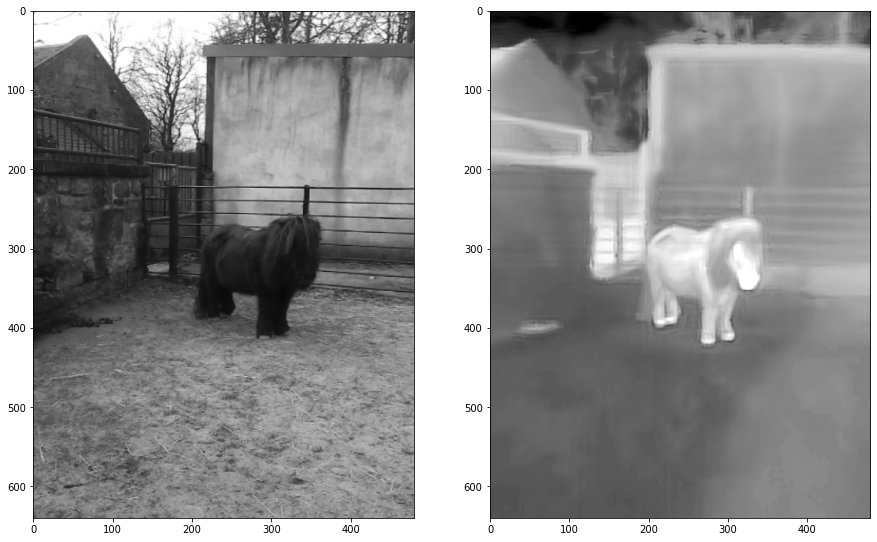

In [0]:
i = 30
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(X_train[i, ..., 0], cmap="gray")
ax2.imshow(y_train[i, ..., 0], cmap="gray")

## U-Net

In [0]:
def unet(x):
    sizes = [5, 7, 7, 7, 7]

    # Encoder
    x = K.layers.Conv2D(4, kernel_size=sizes[0], strides=(1, 1), padding="same", activation="relu")(x)
    bridge_1 = x
    x = K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)

    x = K.layers.Conv2D(8, kernel_size=sizes[1], strides=(1, 1), padding="same", activation="relu")(x)
    bridge_2 = x
    x = K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)

    x = K.layers.Conv2D(16, kernel_size=sizes[2], strides=(1, 1), padding="same", activation="relu")(x)
    bridge_3 = x
    x = K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)

    x = K.layers.Conv2D(32, kernel_size=sizes[3], strides=(1, 1), padding="same", activation="relu")(x)
    bridge_4 = x
    x = K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)

    x = K.layers.Conv2D(64, kernel_size=sizes[4], strides=(1, 1), padding="same", activation="relu")(x)

    # Decoder
    x = K.layers.Conv2DTranspose(32, kernel_size=sizes[4], strides=(2, 2), padding="same", activation="relu")(x)

    x = K.layers.Concatenate()([x, bridge_4])
    x = K.layers.Conv2DTranspose(16, kernel_size=sizes[3], strides=(2, 2), padding="same", activation="relu")(x)

    x = K.layers.Concatenate()([x, bridge_3])
    x = K.layers.Conv2DTranspose(8, kernel_size=sizes[2], strides=(2, 2), padding="same", activation="relu")(x)

    x = K.layers.Concatenate()([x, bridge_2])
    x = K.layers.Conv2DTranspose(4, kernel_size=sizes[1], strides=(2, 2), padding="same", activation="relu")(x)

    x = K.layers.Concatenate()([x, bridge_1])
    x = K.layers.Conv2DTranspose(1, kernel_size=sizes[0], strides=(1, 1), padding="same", activation="relu")(x)

    return x

input_shape = X_train[0].shape
input_tensor = K.layers.Input(input_shape)
output_tensor = unet(input_tensor)

model = K.Model(input_tensor, output_tensor)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
# model.summary()

In [0]:
# model.load_weights("unet_weights")

In [0]:
%%time
# !rm -rf logs
log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

model.fit(X_train, y_train, batch_size=4, epochs=50, callbacks=[tensorboard_callback], verbose=1, validation_data=(X_test, y_test))
model.save_weights("unet_weights")

Epoch 1/50
100/100 [==============================] - 13s 133ms/step - loss: 0.0531 - accuracy: 8.9423e-04 - val_loss: 0.0423 - val_accuracy: 7.7894e-04
Epoch 2/50
100/100 [==============================] - 13s 130ms/step - loss: 0.0312 - accuracy: 0.0016 - val_loss: 0.0411 - val_accuracy: 6.7620e-04
Epoch 3/50
100/100 [==============================] - 13s 130ms/step - loss: 0.0288 - accuracy: 0.0016 - val_loss: 0.0408 - val_accuracy: 2.4394e-04
Epoch 4/50
100/100 [==============================] - 13s 130ms/step - loss: 0.0291 - accuracy: 0.0016 - val_loss: 0.0432 - val_accuracy: 9.4177e-04
Epoch 5/50
100/100 [==============================] - 13s 130ms/step - loss: 0.0252 - accuracy: 0.0017 - val_loss: 0.0445 - val_accuracy: 7.6382e-04
Epoch 6/50
100/100 [==============================] - 13s 130ms/step - loss: 0.0248 - accuracy: 0.0016 - val_loss: 0.0407 - val_accuracy: 0.0011
Epoch 7/50
100/100 [==============================] - 13s 130ms/step - loss: 0.0223 - accuracy: 0.0018 - v

## Autoencoder

In [0]:
model = K.Sequential()

model.add(K.layers.Input(shape=input_shape))

# Encoder
model.add(K.layers.Conv2D(8, kernel_size=(5, 5), strides=(1, 1), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2D(16, kernel_size=(7, 7), strides=(1, 1), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2D(32, kernel_size=(7, 7), strides=(1, 1), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2D(64, kernel_size=(7, 7), strides=(1, 1), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))

# model.add(K.layers.Dropout(0.4))

# Decoder
model.add(K.layers.Conv2DTranspose(32, kernel_size=(7, 7), strides=(2, 2), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2DTranspose(16, kernel_size=(7, 7), strides=(2, 2), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2DTranspose(8, kernel_size=(7, 7), strides=(2, 2), padding="same"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.Dropout(0.4))

model.add(K.layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding="same"))
model.add(K.layers.LeakyReLU())

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

model.fit(X_train, y_train, batch_size=4, epochs=50, callbacks=[tensorboard_callback], verbose=1, validation_data=(X_test, y_test))
model.save_weights("auto_weights")

Epoch 1/50
100/100 [==============================] - 15s 150ms/step - loss: 0.0623 - accuracy: 1.7113e-04 - val_loss: 0.0478 - val_accuracy: 1.9443e-04
Epoch 2/50
100/100 [==============================] - 15s 146ms/step - loss: 0.0359 - accuracy: 0.0011 - val_loss: 0.0493 - val_accuracy: 2.6903e-04
Epoch 3/50
100/100 [==============================] - 15s 147ms/step - loss: 0.0327 - accuracy: 0.0013 - val_loss: 0.0472 - val_accuracy: 3.3854e-04
Epoch 4/50
100/100 [==============================] - 15s 147ms/step - loss: 0.0314 - accuracy: 0.0013 - val_loss: 0.0438 - val_accuracy: 6.6956e-04
Epoch 5/50
100/100 [==============================] - 15s 147ms/step - loss: 0.0302 - accuracy: 0.0013 - val_loss: 0.0484 - val_accuracy: 5.8587e-04
Epoch 6/50
100/100 [==============================] - 15s 147ms/step - loss: 0.0290 - accuracy: 0.0014 - val_loss: 0.0419 - val_accuracy: 6.5396e-04
Epoch 7/50
100/100 [==============================] - 15s 146ms/step - loss: 0.0279 - accuracy: 0.0015

## Evaluation

In [0]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

345


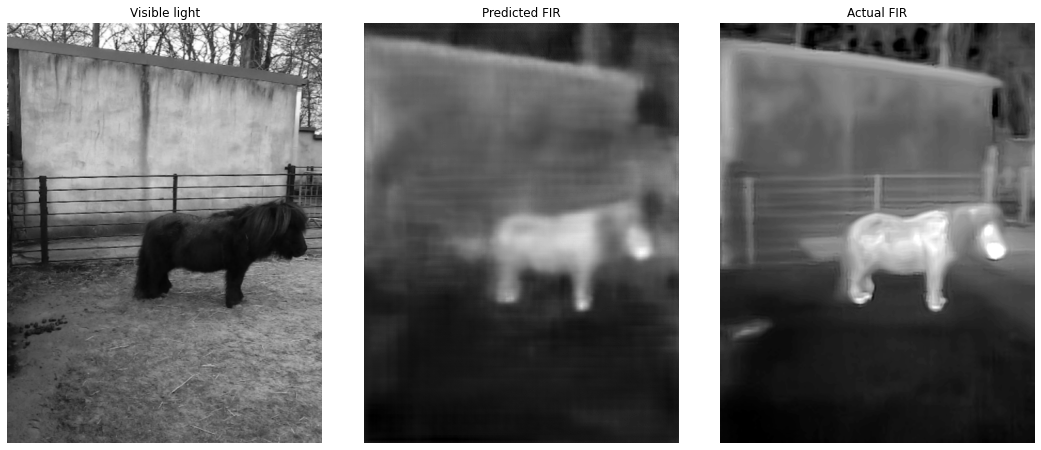

In [0]:
# i = np.random.randint(0, X_test.shape[0] - 1)
i = np.random.randint(0, X_train.shape[0] - 1)
i = 345
print(i)

test_image = X_train[i]
ref_image = y_train[i]
# test_image = X_test[i]
# ref_image = y_test[i]

predicted_image = model.predict(test_image[None, ...])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
fig.tight_layout()
ax1.imshow(test_image[..., 0], cmap="gray")
ax1.set_title("Visible light")
ax1.axis("off")
ax2.imshow(predicted_image[0, ..., 0], cmap="gray")
ax2.set_title("Predicted FIR")
ax2.axis("off")
ax3.imshow(ref_image[..., 0], cmap="gray")
ax3.set_title("Actual FIR")
ax3.axis("off")
pass

In [0]:
!wget -O custom.jpg https://upload.wikimedia.org/wikipedia/commons/2/20/Sandwick_Shetland_Pony.jpg
!wget -O custom_2.jpg https://upload.wikimedia.org/wikipedia/commons/0/05/Shetland_ponies_at_Sandwick.jpg

--2020-03-09 17:43:48--  https://upload.wikimedia.org/wikipedia/commons/2/20/Sandwick_Shetland_Pony.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4908110 (4.7M) [image/jpeg]
Saving to: ‘custom.jpg’

custom.jpg          100%[===================>]   4.68M  18.9MB/s    in 0.2s    

2020-03-09 17:43:49 (18.9 MB/s) - ‘custom.jpg’ saved [4908110/4908110]

--2020-03-09 17:43:50--  https://upload.wikimedia.org/wikipedia/commons/0/05/Shetland_ponies_at_Sandwick.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4653405 (4.4M) [image/jpeg]
Saving to: ‘custom_2.jpg’

custom_2.jpg        100%[===================

In [0]:
!unzip ponies.zip

Archive:  ponies.zip
   creating: ponies/
  inflating: ponies/pony_3.jpg       
  inflating: __MACOSX/ponies/._pony_3.jpg  
  inflating: ponies/pony_2.jpg       
  inflating: __MACOSX/ponies/._pony_2.jpg  
  inflating: ponies/pony_1.jpg       
  inflating: __MACOSX/ponies/._pony_1.jpg  
  inflating: ponies/pony_5.jpg       
  inflating: __MACOSX/ponies/._pony_5.jpg  
  inflating: ponies/pony_4.jpg       
  inflating: __MACOSX/ponies/._pony_4.jpg  
  inflating: ponies/pony_10.jpg      
  inflating: __MACOSX/ponies/._pony_10.jpg  
  inflating: ponies/pony_6.jpg       
  inflating: __MACOSX/ponies/._pony_6.jpg  
  inflating: ponies/pony_7.jpg       
  inflating: __MACOSX/ponies/._pony_7.jpg  
  inflating: ponies/attribution.md   
  inflating: ponies/pony_9.jpg       
  inflating: __MACOSX/ponies/._pony_9.jpg  
  inflating: ponies/pony_8.jpg       
  inflating: __MACOSX/ponies/._pony_8.jpg  


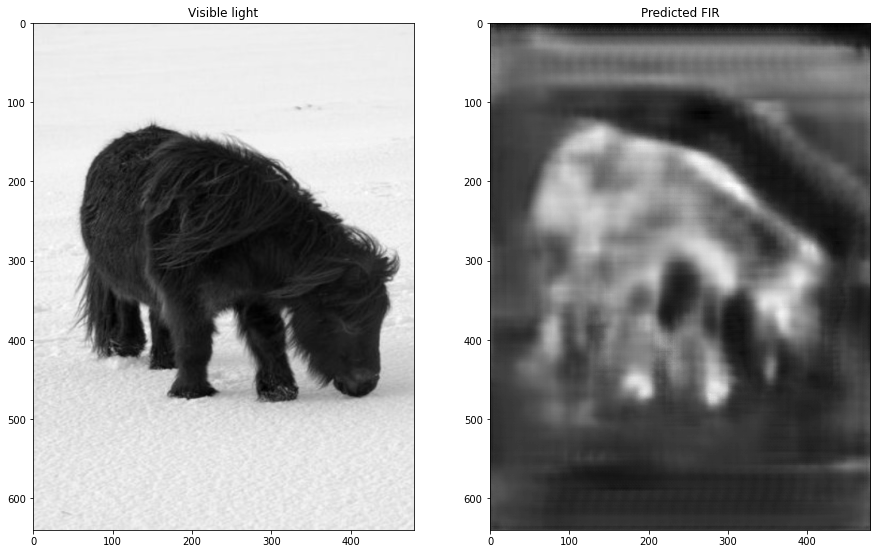

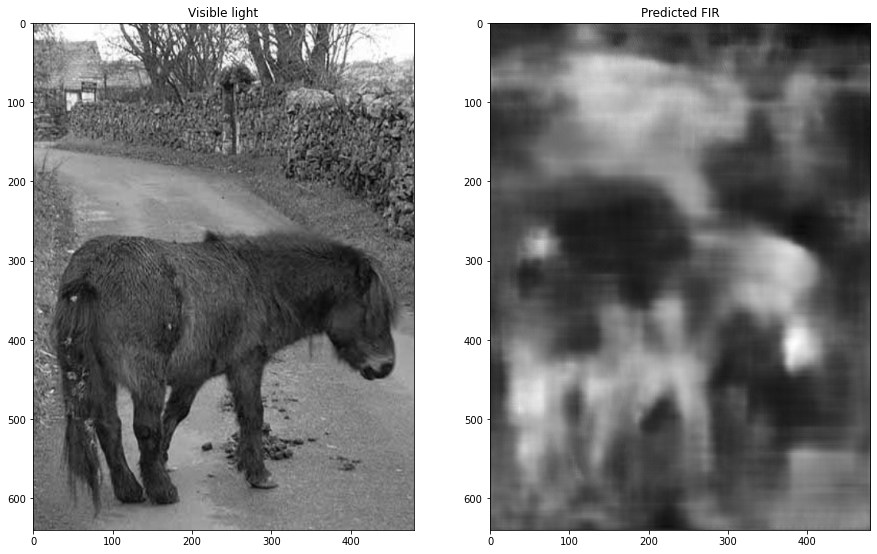

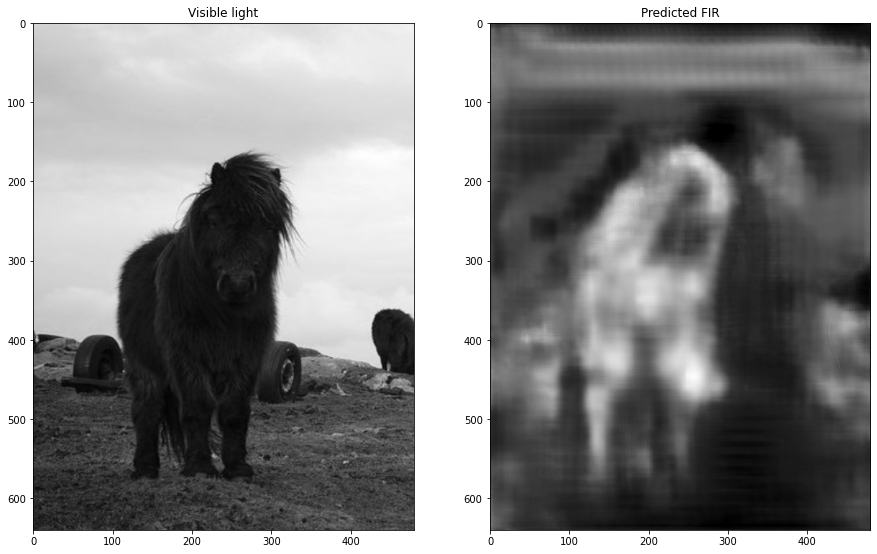

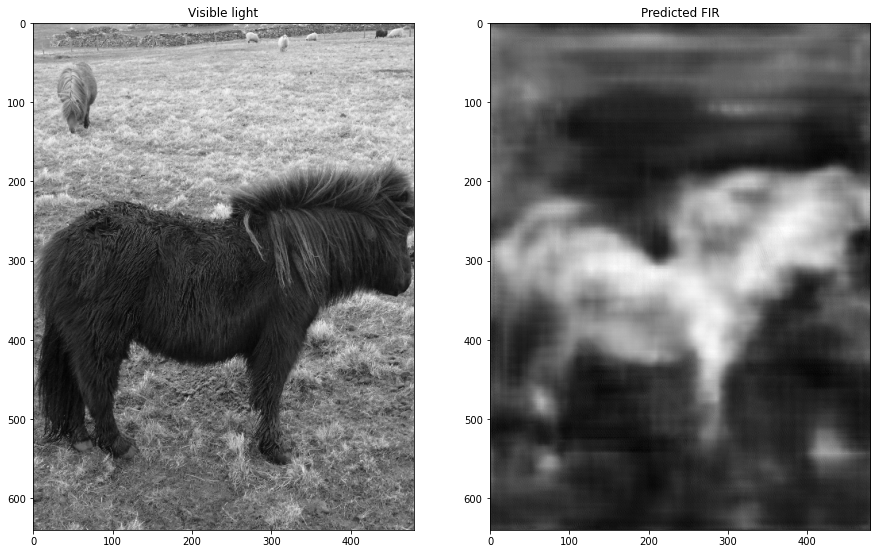

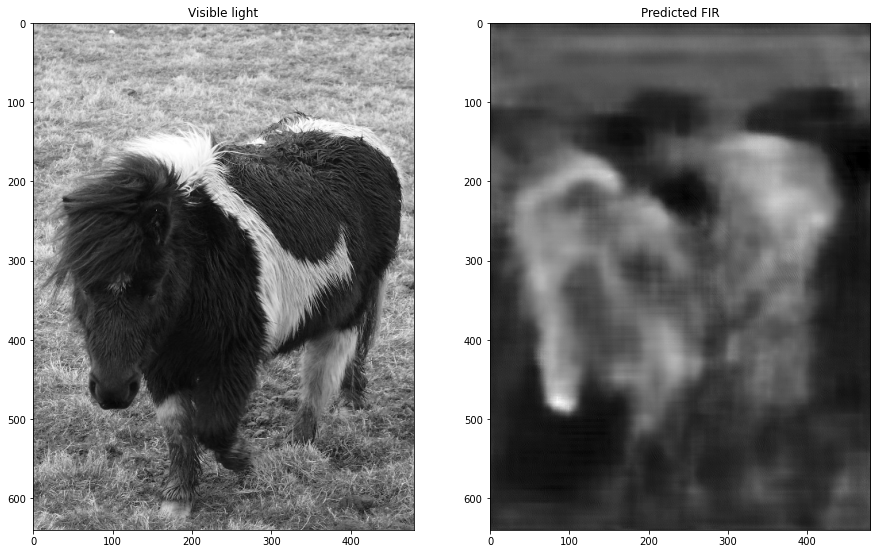

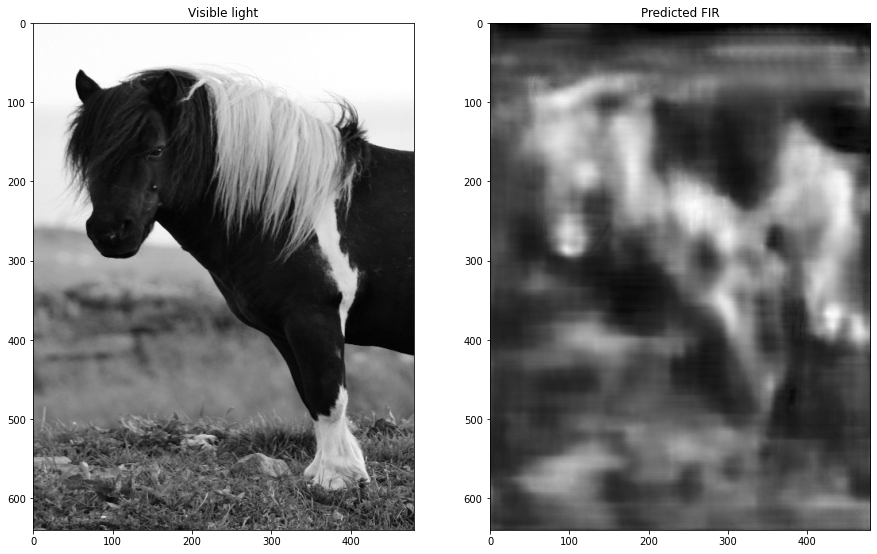

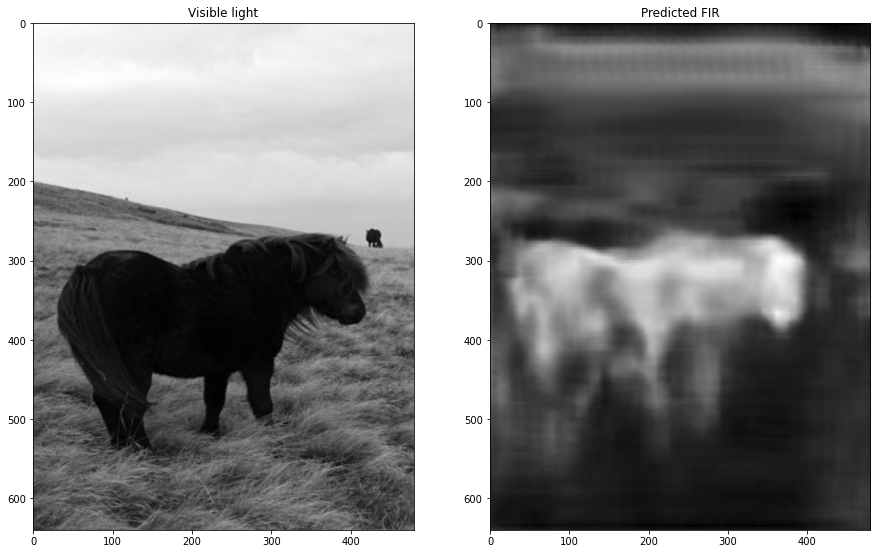

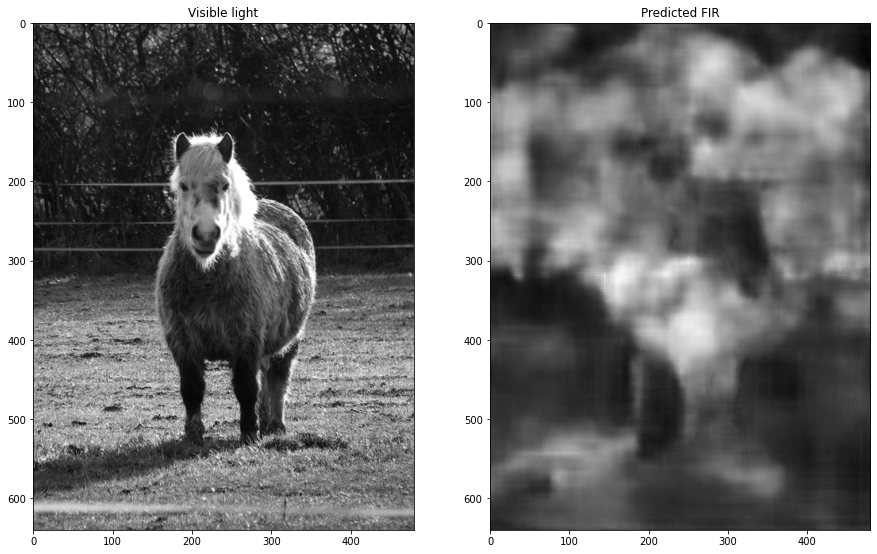

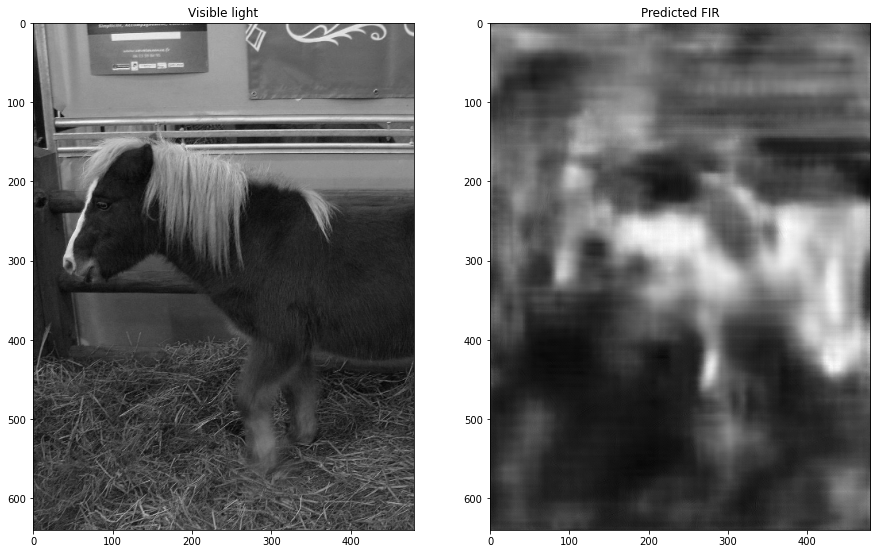

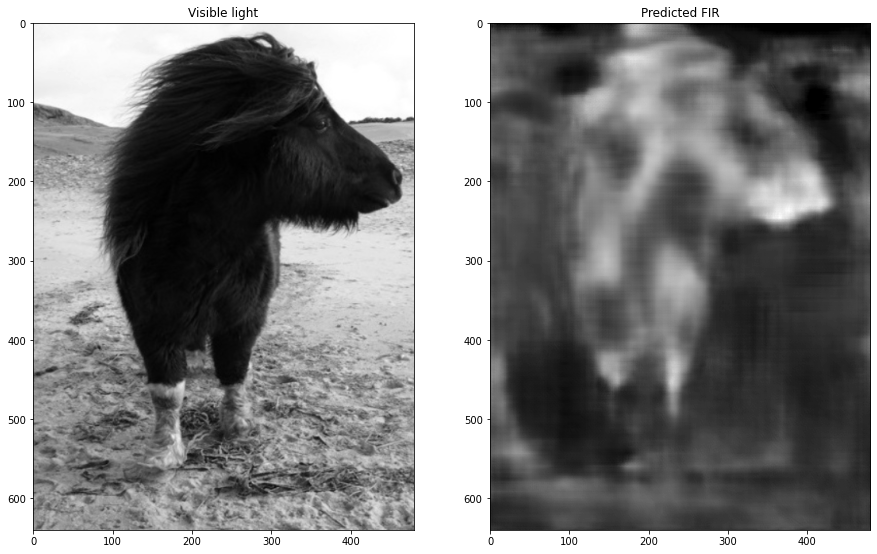

In [0]:
# Custom image

for image in os.listdir("ponies"):
    if not image.startswith("pony"):
        continue
    transfer_image = cv2.imread(os.path.join("ponies", image)) / 255
    transfer_image = np.mean(transfer_image, axis=-1)

    # Crop
    # transfer_image = cv2.GaussianBlur(transfer_image, (7, 7), sigmaX=3)
    transfer_image = cv2.resize(transfer_image, (input_shape[1], input_shape[0]))[..., None]

    predicted_transfer_image = model.predict(transfer_image[None, ...])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    ax1.imshow(transfer_image[..., 0], cmap="gray")
    ax1.set_title("Visible light")
    ax2.imshow(predicted_transfer_image[0, ..., 0], cmap="gray")
    ax2.set_title("Predicted FIR")

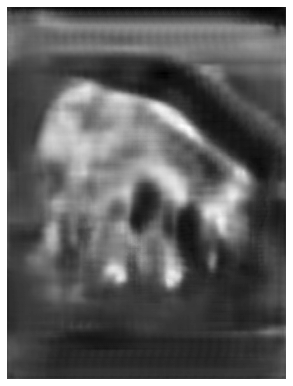

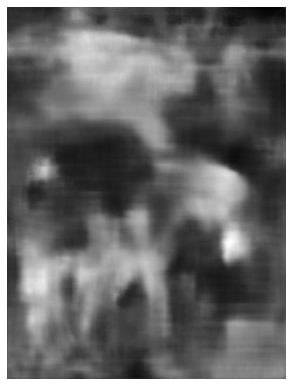

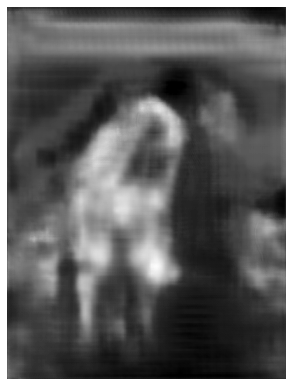

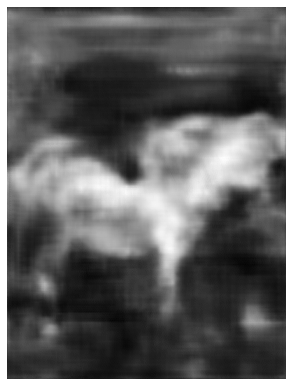

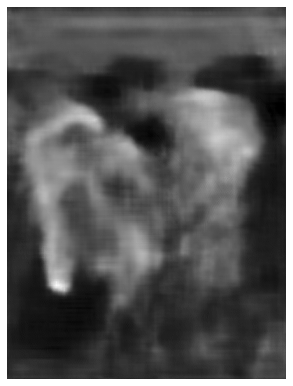

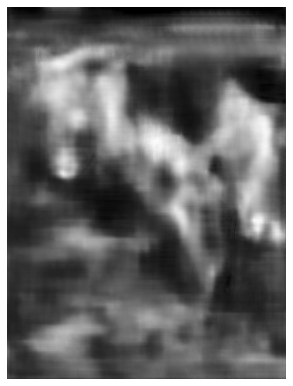

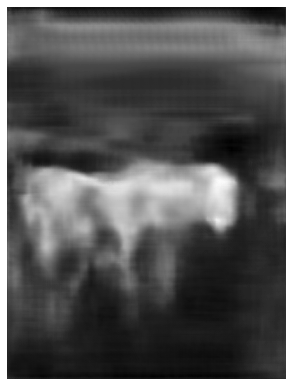

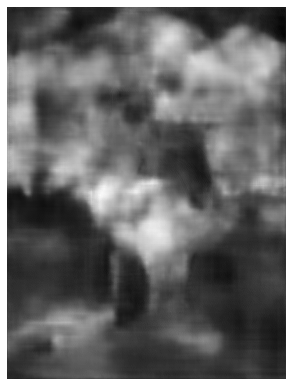

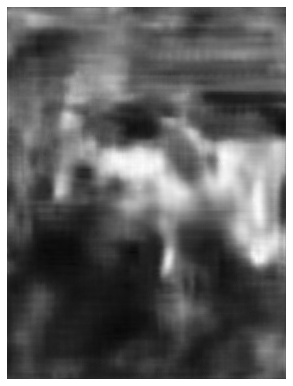

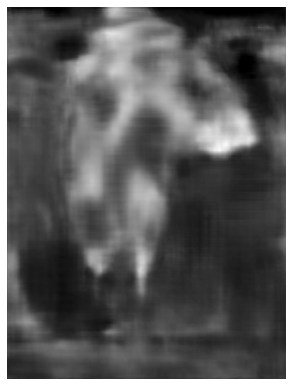

In [0]:
# Generate images for dissertation


for image in os.listdir("ponies"):
    if not image.startswith("pony"):
        continue
    transfer_image = cv2.imread(os.path.join("ponies", image)) / 255
    transfer_image = np.mean(transfer_image, axis=-1)

    # Crop
    transfer_image = cv2.resize(transfer_image, (input_shape[1], input_shape[0]))[..., None]

    predicted_transfer_image = model.predict(transfer_image[None, ...])

    plt.figure(figsize=(5,10))
    plt.imshow(predicted_transfer_image[0, ..., 0], cmap="gray")
    plt.axis("off")